In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

iris = load_iris()
X = iris.data
y = iris.target

print(X.shape)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

y_pred = kmeans.labels_

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

labels = np.zeros_like(y_pred)
for i in range(3):
    mask = (y_pred == i)
    labels[mask] = mode(y_encoded[mask])[0]
    
accuracy = accuracy_score(y_encoded, labels)

print(f"Kmeans Accuracy:{accuracy:.4f}")


(150, 4)
Kmeans Accuracy:0.8933


d:\anaconda\envs\mi_clustering\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda\envs\mi_clustering\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\1390107718.py:25: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import skfuzzy as fuzz
from scipy.stats import mode

iris = load_iris()
X = iris.data 
y = iris.target 

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

n_clusters = 3

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

u = u / np.sum(u, axis=0, keepdims=True)
print(u[:,0])

y_pred = np.argmax(u, axis=0)

labels = np.zeros_like(y_pred)
for i in range(n_clusters):
    mask = (y_pred == i)
    labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]

accuracy = accuracy_score(y_encoded, labels)

print(f"Fuzzy C-Means Accuracy:{accuracy:.4f}")


[0.00230444 0.00107193 0.99662363]
Fuzzy C-Means Accuracy:0.8933


[[1.         0.99599866 0.99997391 ... 0.65347343 0.6339168  0.63315839]
 [0.99599866 1.         0.99660709 ... 0.70898277 0.68625679 0.68483481]
 [0.99997391 0.99660709 1.         ... 0.65755616 0.63763128 0.6368058 ]
 ...
 [0.65347343 0.70898277 0.65755616 ... 1.         0.99570813 0.99446012]
 [0.6339168  0.68625679 0.63763128 ... 0.99570813 1.         0.99991588]
 [0.63315839 0.68483481 0.6368058  ... 0.99446012 0.99991588 1.        ]]


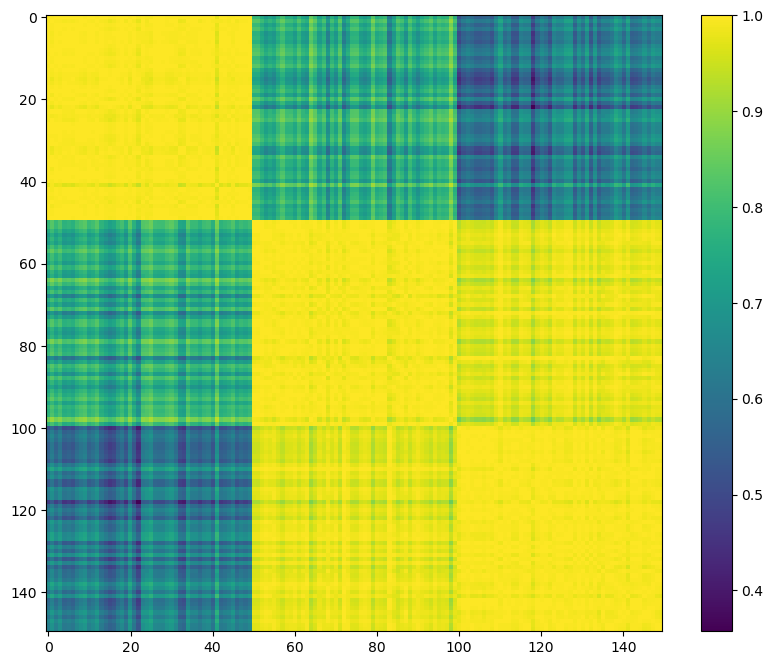

In [11]:
from scipy.spatial.distance import correlation
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
 
pearson_similarity_matrix = 1 - pairwise_distances(X, metric='correlation')

print(pearson_similarity_matrix)
plt.figure(figsize=(10, 8))
plt.imshow(pearson_similarity_matrix)
plt.colorbar()
plt.show()


In [12]:
def compute_P_C(P, N):
    return np.sum(P,axis=0)/N

def compute_s_C(P, similarity_matrix, C, N):
    P_C = compute_P_C(P, N)
    P_column = P[:, C]
    norm_factor = (P_C[C] * N) ** 2
    s_C = np.sum(similarity_matrix * np.outer(P_column, P_column)) / norm_factor
    return s_C
    
 
def compute_s_C_i(P, similarity_matrix, C, i, N):
    P_C = compute_P_C(P, N)
    s_C_i = 0
    for j in range(N):
        s_C_i += similarity_matrix[i, j]*P[j, C]
    s_C_i /= (P_C[C]*N)
    return s_C_i

def soft_clustering(similarity_matrix, T, Nc, epsilon):
    N = similarity_matrix.shape[0]
    np.random.seed(42)
    P = np.random.rand(N, Nc)
    P = P / P.sum(axis=1, keepdims=True)  # Normalize distribution
    count = 0
    P_new = np.zeros_like(P)
    
    while True:
        P_C = compute_P_C(P,N)
        for C in range(Nc):
          s_C = compute_s_C(P, similarity_matrix, C, N)
          s_C_i = np.zeros(N)
          for i in range(N):
              s_C_i[i] = compute_s_C_i(P, similarity_matrix, C, i, N)  
          exponent = (1 / T) * (2 * s_C_i - s_C)
          P_new[:,C] = P_C[C] * np.exp(exponent)
        # Normalize P_new
        P_new = P_new / P_new.sum(axis=1, keepdims=True)

        # Check convergence
        if np.all(np.abs(P_new - P) <= epsilon):
            break
        
        count += 1
        print(f"Epoch {count}, diff is {np.sum(np.abs(P_new - P))}")
        
        P = P_new.copy()

    return P

In [13]:
T = 1.0/50
Nc = 3
N = 150
epsilon = 1e-4

P_C_i = soft_clustering(pearson_similarity_matrix,T,Nc,epsilon)
np.savetxt("temp/iris_opt_P_C_i.csv",P_C_i,delimiter=",")

Epoch 1, diff is 116.18555205993223
Epoch 2, diff is 40.99191580717172
Epoch 3, diff is 8.374337185406826
Epoch 4, diff is 7.111994254202081
Epoch 5, diff is 4.98159596863804
Epoch 6, diff is 3.0304942978248577
Epoch 7, diff is 1.7582275155000604
Epoch 8, diff is 1.1107634113534786
Epoch 9, diff is 0.9028006065255298
Epoch 10, diff is 0.825463278575693
Epoch 11, diff is 0.7579038372567657
Epoch 12, diff is 0.6963155767431458
Epoch 13, diff is 0.6398178274732043
Epoch 14, diff is 0.5878460711919747
Epoch 15, diff is 0.5399912863575946
Epoch 16, diff is 0.49592252474290055
Epoch 17, diff is 0.45535125934778314
Epoch 18, diff is 0.4180154010140186
Epoch 19, diff is 0.3836722552579836
Epoch 20, diff is 0.3520954134245238
Epoch 21, diff is 0.3230732989889663
Epoch 22, diff is 0.29640835656984976
Epoch 23, diff is 0.27191645052225677
Epoch 24, diff is 0.24942630057522203
Epoch 25, diff is 0.22877889621034522
Epoch 26, diff is 0.20982687917323317
Epoch 27, diff is 0.19243390153036163
Epoch 28

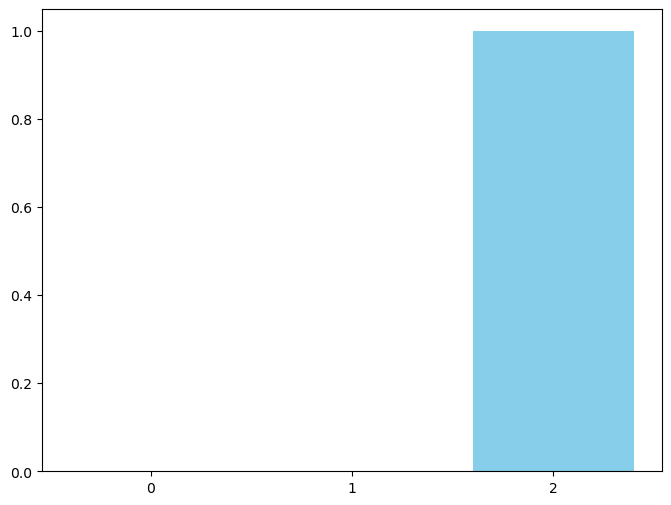

0.9999999999914341


In [14]:
P_C_i = np.loadtxt("temp/iris_opt_P_C_i.csv",delimiter=",")

def draw(P_C_i,i):
    plt.figure(figsize=(8, 6))
    x = np.arange(0, len(P_C_i[i]), 1)
    plt.bar(x, P_C_i[i], width=0.8, color='skyblue', align='center')
    plt.xticks(x)
    plt.show()
    print(np.max(P_C_i[i]))
    
draw(P_C_i,0)

In [15]:
y_pred = np.argmax(P_C_i, axis=1)

labels = np.zeros_like(y_pred)
for i in range(n_clusters):
    mask = (y_pred == i)
    labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]

accuracy = accuracy_score(y_encoded, labels)

print(f"Accuracy:{accuracy:.4f}")
print(y_encoded)
print(y_pred)

Accuracy:0.9733
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


Epoch 1, diff is 79.68816496167179
Epoch 2, diff is 77.66396313541807
Epoch 3, diff is 7.7038317791213675
Epoch 4, diff is 3.7508265989505998
Epoch 5, diff is 2.177882087350215
Epoch 6, diff is 1.2779099659219986
Epoch 7, diff is 0.7506540589437167
Epoch 8, diff is 0.4409866320974658
Epoch 9, diff is 0.25903845748087617
Epoch 10, diff is 0.15214274760757124
Epoch 11, diff is 0.08935104586298405
Epoch 12, diff is 0.05247138788724363
Epoch 13, diff is 0.03081268522737873
Epoch 14, diff is 0.01809367847189529
Epoch 15, diff is 0.010624742067298132
0.6666666666666666
Epoch 1, diff is 81.0646248564324
Epoch 2, diff is 77.01082568658566
Epoch 3, diff is 7.353795225053496
Epoch 4, diff is 3.7740048954121628


d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 5, diff is 2.3011951835050883
Epoch 6, diff is 1.416683319446353
Epoch 7, diff is 0.8735614434306945
Epoch 8, diff is 0.5388286030144123
Epoch 9, diff is 0.3323434589173998
Epoch 10, diff is 0.20496158637562523
Epoch 11, diff is 0.12638977301206628
Epoch 12, diff is 0.07793233771115457
Epoch 13, diff is 0.04805080376336068
Epoch 14, diff is 0.029625709908439442
Epoch 15, diff is 0.01826532605065819
Epoch 16, diff is 0.011261082925177253
0.6666666666666666
Epoch 1, diff is 82.46656158854756
Epoch 2, diff is 76.13405330312872
Epoch 3, diff is 7.02505035856773
Epoch 4, diff is 3.7985719565893548
Epoch 5, diff is 2.4233384615026186
Epoch 6, diff is 1.5611185470309827


d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 7, diff is 1.0080529144820825
Epoch 8, diff is 0.6513494832823848
Epoch 9, diff is 0.4209012638723054
Epoch 10, diff is 0.27196289526419964
Epoch 11, diff is 0.17570771812745004
Epoch 12, diff is 0.11350910385337389
Epoch 13, diff is 0.07332289928769485
Epoch 14, diff is 0.04736165056053178
Epoch 15, diff is 0.03059139324006786
Epoch 16, diff is 0.019758857845010445
Epoch 17, diff is 0.01276197614837458
Epoch 18, diff is 0.008242705373390228
0.6666666666666666
Epoch 1, diff is 83.9087690405155
Epoch 2, diff is 75.08423035357836
Epoch 3, diff is 6.695544506431583
Epoch 4, diff is 3.8068596282106597
Epoch 5, diff is 2.532324041352861
Epoch 6, diff is 1.7025405639856501


d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 7, diff is 1.1485059175863535
Epoch 8, diff is 0.7756662120242095
Epoch 9, diff is 0.5240282004601218
Epoch 10, diff is 0.35402803620696544
Epoch 11, diff is 0.23915652496737055
Epoch 12, diff is 0.16154088258314947
Epoch 13, diff is 0.1091049189653959
Epoch 14, diff is 0.0736845617190752
Epoch 15, diff is 0.04976074553104104
Epoch 16, diff is 0.03360328524287734
Epoch 17, diff is 0.022691633529505637
Epoch 18, diff is 0.015322947047607888
Epoch 19, diff is 0.01034698245009502
0.6666666666666666
Epoch 1, diff is 85.35937972699111
Epoch 2, diff is 73.90118314789984
Epoch 3, diff is 6.355837091199627
Epoch 4, diff is 3.786185484903572
Epoch 5, diff is 2.617535908648946
Epoch 6, diff is 1.831725877467159


d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 7, diff is 1.287759667380191
Epoch 8, diff is 0.9070532284023023
Epoch 9, diff is 0.6393497125021235
Epoch 10, diff is 0.45074355172093344
Epoch 11, diff is 0.3177723765679726
Epoch 12, diff is 0.22401016194310547
Epoch 13, diff is 0.1578987833057869
Epoch 14, diff is 0.11128930947368962
Epoch 15, diff is 0.07843295293205735
Epoch 16, diff is 0.055274004626770075
Epoch 17, diff is 0.03895168962558015
Epoch 18, diff is 0.02744853815728845
Epoch 19, diff is 0.01934207790722168
Epoch 20, diff is 0.013629520267024603
Epoch 21, diff is 0.009604027528698152
0.6666666666666666
Epoch 1, diff is 86.79851527202959
Epoch 2, diff is 72.61263917573088
Epoch 3, diff is 5.9975011388202795
Epoch 4, diff is 3.7280561311782066


d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 5, diff is 2.6699801345432013
Epoch 6, diff is 1.9393518805540648
Epoch 7, diff is 1.4173494344212543
Epoch 8, diff is 1.0388420742786384
Epoch 9, diff is 0.7624094567665113
Epoch 10, diff is 0.5598325686954161
Epoch 11, diff is 0.41114928855943494
Epoch 12, diff is 0.301953987441307
Epoch 13, diff is 0.221744865336621
Epoch 14, diff is 0.16282844318811254
Epoch 15, diff is 0.1195562422356122
Epoch 16, diff is 0.08777772849084252
Epoch 17, diff is 0.06444245626938473
Epoch 18, diff is 0.0473086643071818
Epoch 19, diff is 0.034729180977141394
Epoch 20, diff is 0.025493954082167702
Epoch 21, diff is 0.018714207357632618
Epoch 22, diff is 0.013737236862505605
Epoch 23, diff is 0.010083763735718539
Epoch 24, diff is 0.007401887395957298
0.6666666666666666
Epoch 1, diff is 88.23624357727275
Epoch 2, diff is 71.24578994829477
Epoch 3, diff is 5.616144975796624


d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 4, diff is 3.6268443073113215
Epoch 5, diff is 2.6826687797981155
Epoch 6, diff is 2.0164145392480037
Epoch 7, diff is 1.5278341975026228
Epoch 8, diff is 1.1624426788288893
Epoch 9, diff is 0.8863392444669996
Epoch 10, diff is 0.6765398835470914
Epoch 11, diff is 0.5166540652582431
Epoch 12, diff is 0.39462695003513065
Epoch 13, diff is 0.30143056563733905
Epoch 14, diff is 0.23023453297395294
Epoch 15, diff is 0.17584263488161397
Epoch 16, diff is 0.13429071133458637
Epoch 17, diff is 0.10255052548140392
Epoch 18, diff is 0.07830757782546309
Epoch 19, diff is 0.0597926719688671
Epoch 20, diff is 0.04565353936700136
Epoch 21, diff is 0.03485674360644207
Epoch 22, diff is 0.02661264325918599
Epoch 23, diff is 0.020317977632090367
Epoch 24, diff is 0.015511941180926045
Epoch 25, diff is 0.01184258636461448
Epoch 26, diff is 0.009041134154965597
0.6666666666666666
Epoch 1, diff is 89.65493341038886
Epoch 2, diff is 69.82135698539774
Epoch 3, diff is 5.210374982417455
Epoch 4, diff 

d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 5, diff is 2.6498256129679882
Epoch 6, diff is 2.0547477726443795
Epoch 7, diff is 1.6092739864577104
Epoch 8, diff is 1.2675800689859227
Epoch 9, diff is 1.0017069810128023
Epoch 10, diff is 0.7930773359718475
Epoch 11, diff is 0.6285470361961134
Epoch 12, diff is 0.49841818574554336
Epoch 13, diff is 0.3953300648207363
Epoch 14, diff is 0.31359242671716325
Epoch 15, diff is 0.24875572648591868
Epoch 16, diff is 0.19731648037669902
Epoch 17, diff is 0.156505000925222
Epoch 18, diff is 0.12412679727168587
Epoch 19, diff is 0.0984410900520431
Epoch 20, diff is 0.07806626066556412
Epoch 21, diff is 0.0619055457777261
Epoch 22, diff is 0.04908831273853755
Epoch 23, diff is 0.03892350572255256
Epoch 24, diff is 0.030862683109559842
Epoch 25, diff is 0.024470650815172912
Epoch 26, diff is 0.01940212680411315
Epoch 27, diff is 0.015383199931269739
Epoch 28, diff is 0.012196601303430487
Epoch 29, diff is 0.00967000726487783
Epoch 30, diff is 0.007666752427470679
0.6666666666666666
Epoch

d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 3, diff is 4.781912124017111
Epoch 4, diff is 3.2855594984126317
Epoch 5, diff is 2.567699260246834
Epoch 6, diff is 2.0473846641954117
Epoch 7, diff is 1.6519048437952655
Epoch 8, diff is 1.3428566549273577
Epoch 9, diff is 1.0967220624824308
Epoch 10, diff is 0.89833975169438
Epoch 11, diff is 0.7371970672549629
Epoch 12, diff is 0.6056433648288378
Epoch 13, diff is 0.49790012576300463
Epoch 14, diff is 0.40948008451799733
Epoch 15, diff is 0.3368285473058797
Epoch 16, diff is 0.2770903418462128
Epoch 17, diff is 0.22795066539164424
Epoch 18, diff is 0.18752128632750129
Epoch 19, diff is 0.15425589428748432
Epoch 20, diff is 0.12688510644719705
Epoch 21, diff is 0.10436536248216183
Epoch 22, diff is 0.08583805152184493
Epoch 23, diff is 0.07059644123895173
Epoch 24, diff is 0.05805871531139636
Epoch 25, diff is 0.04774588498173109
Epoch 26, diff is 0.03926364074504461
Epoch 27, diff is 0.03228741639534487
Epoch 28, diff is 0.026550086069698022
Epoch 29, diff is 0.02183182629305

d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 9, diff is 1.1580243327743935
Epoch 10, diff is 0.9782321214545298
Epoch 11, diff is 0.8287862241212142
Epoch 12, diff is 0.7035842780249948
Epoch 13, diff is 0.5981105615313779
Epoch 14, diff is 0.508911626826785
Epoch 15, diff is 0.43327368585928
Epoch 16, diff is 0.3690173394640848
Epoch 17, diff is 0.3143625657649688
Epoch 18, diff is 0.26783687636469145
Epoch 19, diff is 0.22821066603348975
Epoch 20, diff is 0.1944501424733222
Epoch 21, diff is 0.1656819434742097
Epoch 22, diff is 0.14116576342300852
Epoch 23, diff is 0.12027264833045742
Epoch 24, diff is 0.10246743623208844
Epoch 25, diff is 0.0872943261851913
Epoch 26, diff is 0.07436487699770526
Epoch 27, diff is 0.06334793977490774
Epoch 28, diff is 0.0539611605729848
Epoch 29, diff is 0.04596377774040694
Epoch 30, diff is 0.03915049923494994
Epoch 31, diff is 0.033346288349193676
Epoch 32, diff is 0.02840191797522556
Epoch 33, diff is 0.02419017763604047
Epoch 34, diff is 0.020602636368765196
Epoch 35, diff is 0.0175468

d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 10, diff is 1.0170449984069176
Epoch 11, diff is 0.8861551205128997
Epoch 12, diff is 0.7745631904059395
Epoch 13, diff is 0.6786205095897778
Epoch 14, diff is 0.5956005062434264
Epoch 15, diff is 0.5234102147179968
Epoch 16, diff is 0.46040381578765405
Epoch 17, diff is 0.4052591988933751
Epoch 18, diff is 0.35689444293113876
Epoch 19, diff is 0.31441012911814925
Epoch 20, diff is 0.27704868208538
Epoch 21, diff is 0.24416512240004112
Epoch 22, diff is 0.21520558482429372
Epoch 23, diff is 0.18969120144189314
Epoch 24, diff is 0.1672057485876177
Epoch 25, diff is 0.14738597779226703
Epoch 26, diff is 0.12991389466978004
Epoch 27, diff is 0.11451047853448401
Epoch 28, diff is 0.10093048916416908
Epoch 29, diff is 0.08895811104807563
Epoch 30, diff is 0.07840325624406502
Epoch 31, diff is 0.06909839554310042
Epoch 32, diff is 0.060895821271309145
Epoch 33, diff is 0.05366526855185009
Epoch 34, diff is 0.04729183845807687
Epoch 35, diff is 0.04167417841625566
Epoch 36, diff is 0.03

d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 1, diff is 95.18217296572914
Epoch 2, diff is 63.86035868489103
Epoch 3, diff is 3.36480036488096
Epoch 4, diff is 2.4337017936842464
Epoch 5, diff is 2.0144339845793504
Epoch 6, diff is 1.707940294427206
Epoch 7, diff is 1.471286653126879
Epoch 8, diff is 1.2827507832510023
Epoch 9, diff is 1.1287070767934848
Epoch 10, diff is 1.0003217481508646
Epoch 11, diff is 0.8915730117876628
Epoch 12, diff is 0.7982672178024119
Epoch 13, diff is 0.7172903789170719
Epoch 14, diff is 0.6463676330831262
Epoch 15, diff is 0.5837869242402077
Epoch 16, diff is 0.528228124408549
Epoch 17, diff is 0.4786548612466921
Epoch 18, diff is 0.4342397974592834
Epoch 19, diff is 0.3943120739660245
Epoch 20, diff is 0.35831974750462126
Epoch 21, diff is 0.3258025591423508
Epoch 22, diff is 0.29637193506745096
Epoch 23, diff is 0.26969612170918644
Epoch 24, diff is 0.2454890108825463
Epoch 25, diff is 0.22350164598507383
Epoch 26, diff is 0.20351569530320285
Epoch 27, diff is 0.1853383815226356
Epoch 28, di

d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


0.6666666666666666
Epoch 1, diff is 96.53422700407557
Epoch 2, diff is 62.35132180857039
Epoch 3, diff is 2.852290950510811
Epoch 4, diff is 2.0679467443165316
Epoch 5, diff is 1.732357501290642
Epoch 6, diff is 1.486981098152261
Epoch 7, diff is 1.2968222360990258
Epoch 8, diff is 1.1451606739211353
Epoch 9, diff is 1.021508710975048
Epoch 10, diff is 0.9186990905070007
Epoch 11, diff is 0.8318485367360473
Epoch 12, diff is 0.7574725847544905
Epoch 13, diff is 0.6930242525620564
Epoch 14, diff is 0.6366054815948277
Epoch 15, diff is 0.5867942468882582
Epoch 16, diff is 0.5424452564075037
Epoch 17, diff is 0.5026870292042713
Epoch 18, diff is 0.46682822555977965
Epoch 19, diff is 0.4343139426642093
Epoch 20, diff is 0.40469395985080087
Epoch 21, diff is 0.3775993179792384
Epoch 22, diff is 0.3527248107616895
Epoch 23, diff is 0.3298157349093251
Epoch 24, diff is 0.3086577516361385
Epoch 25, diff is 0.28906905058098353
Epoch 26, diff is 0.2708942376682965
Epoch 27, diff is 0.25399952773

d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 4, diff is 1.666497245027739
Epoch 5, diff is 1.4073663122106987
Epoch 6, diff is 1.217649298971822
Epoch 7, diff is 1.069311173206685
Epoch 8, diff is 0.9503611923608091
Epoch 9, diff is 0.8530943766845789
Epoch 10, diff is 0.7722997339262838
Epoch 11, diff is 0.7042152154323632
Epoch 12, diff is 0.64613274211451
Epoch 13, diff is 0.5960551272656212
Epoch 14, diff is 0.5524721432650193
Epoch 15, diff is 0.5142226801629557
Epoch 16, diff is 0.48040081250647165
Epoch 17, diff is 0.45029036814351164
Epoch 18, diff is 0.42332562720384515
Epoch 19, diff is 0.3990403125966834
Epoch 20, diff is 0.3770500730144143
Epoch 21, diff is 0.35704388783182334
Epoch 22, diff is 0.3387634938452019
Epoch 23, diff is 0.32199283898826975
Epoch 24, diff is 0.306549942711133
Epoch 25, diff is 0.29228055023157323
Epoch 26, diff is 0.2790531390060307
Epoch 27, diff is 0.2667549551272071
Epoch 28, diff is 0.25528884180951206
Epoch 29, diff is 0.24457068253785874
Epoch 30, diff is 0.2345273252323239
Epoch

d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 3, diff is 1.8163294503590335
Epoch 4, diff is 1.2343541434249106
Epoch 5, diff is 1.0449282599603507
Epoch 6, diff is 0.9071506789057945
Epoch 7, diff is 0.7976295669026815
Epoch 8, diff is 0.7085985341211847
Epoch 9, diff is 0.6350232874481216
Epoch 10, diff is 0.5733855748353162
Epoch 11, diff is 0.5211786915982641
Epoch 12, diff is 0.47646795984429197
Epoch 13, diff is 0.437826314416088
Epoch 14, diff is 0.40415999449310686
Epoch 15, diff is 0.37461618554786297
Epoch 16, diff is 0.34852118721023073
Epoch 17, diff is 0.32534386773771395
Epoch 18, diff is 0.3046488279527191
Epoch 19, diff is 0.2860715546964697
Epoch 20, diff is 0.26932050024415505
Epoch 21, diff is 0.2541537611953451
Epoch 22, diff is 0.24036912531355037
Epoch 23, diff is 0.227796393295616
Epoch 24, diff is 0.21629139598360336
Epoch 25, diff is 0.20573128932396612
Epoch 26, diff is 0.19601082226252242
Epoch 27, diff is 0.1870393526273162
Epoch 28, diff is 0.17873844322552357
Epoch 29, diff is 0.1710399117831952

d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\envs\mi_clustering\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wwlzj\AppData\Local\Temp\ipykernel_55092\3079284675.py:7: RuntimeWarning: invalid value encountered in cast
  labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]


Epoch 1, diff is 100.40899750352776
Epoch 2, diff is 57.86328140036736
Epoch 3, diff is 1.3323420317144437
Epoch 4, diff is 0.7755029606117274
Epoch 5, diff is 0.6514904927517495
Epoch 6, diff is 0.5646638155758829
Epoch 7, diff is 0.49423483490854003
Epoch 8, diff is 0.43578605803471837
Epoch 9, diff is 0.38664981766016465
Epoch 10, diff is 0.3449181838808274
Epoch 11, diff is 0.3091819682770866
Epoch 12, diff is 0.2783056755719055
Epoch 13, diff is 0.2514408149112284
Epoch 14, diff is 0.22794793757638682
Epoch 15, diff is 0.20726583235901982
Epoch 16, diff is 0.18896238188623168
Epoch 17, diff is 0.17268978696433662
Epoch 18, diff is 0.15816256818129665
Epoch 19, diff is 0.14514445787183544
Epoch 20, diff is 0.13343842608626577
Epoch 21, diff is 0.12287900757185787
Epoch 22, diff is 0.11332633893728616
Epoch 23, diff is 0.10466148129405048
Epoch 24, diff is 0.09678271926791476
Epoch 25, diff is 0.08960260882428221
Epoch 26, diff is 0.08305434711886471
Epoch 27, diff is 0.077073620782

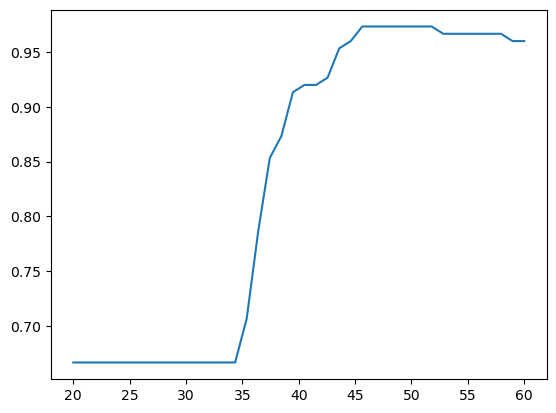

In [16]:
acc = []
for t in range(20,60):
  P_C_i = soft_clustering(pearson_similarity_matrix,1/t,Nc,epsilon)
  y_pred = np.argmax(P_C_i, axis=1)
  for i in range(n_clusters):
    mask = (y_pred == i)
    labels[mask] = mode(y_encoded[mask],keepdims=True)[0][0]
  accuracy = accuracy_score(y_encoded, labels)
  print(accuracy)
  acc.append(accuracy)

X = np.linspace(20,60,40)
plt.plot(X,acc)
plt.show()
